In [ ]:
 pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


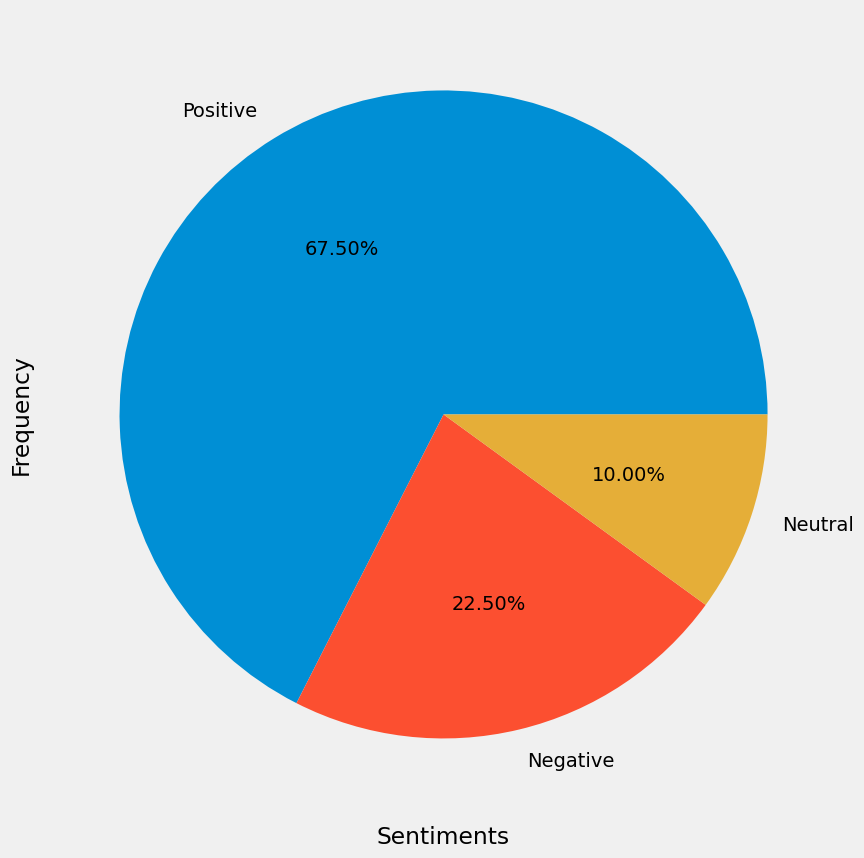

In [ ]:
# Import packages
import pandas as pd
import string
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

nltk.downloader.download('vader_lexicon')
nltk.download('punkt')

# Read and take a look at the trustpilot csv file
df_trustpilot = pd.read_csv("cleaned_reviews.csv", encoding='latin1')
df_trustpilot.head()

# Preprocessing for sentimental analysis
def sentiment_clean_text(text):
    if "|" in text:
        text = text.split("|")[1]
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Preprocessing for the emotional analysis
def emotion_clean_text(text):
    text = word_tokenize(text, "english")
    stop_words = get_stop_words("english")
    text_list = []
    for word in text:
        if word not in stop_words:
            text_list.append(word)
    return text_list

def emotion_mapping(file, dictionary):
    for line in file:
        clear_line = line.replace("\n", '').replace(",", '').replace("'", '').strip()
        word, emotion = clear_line.split(':')
        dictionary[word] = emotion
    return dictionary

def analyze_sentiment(text):
    scores = SentimentIntensityAnalyzer().polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.05:
        return 1  # Positive sentiment
    elif compound_score <= -0.05:
        return 0  # Negative sentiment
    else:
        return 2  # Neutral sentiment

cleaned_text = ""
temp_emotion_list = []
score = 0
emotion_dict = {}
words_score_dict = {}
moods_list_trustpilot = []

main_categories = ["bank","service","fraud","customer support","price","time","staff","business"]
temp_category_list = []

emotion_file = open("Emotions.txt","r",encoding="utf-8")
emotion_dict = emotion_mapping(emotion_file,emotion_dict)
emotion_file.close()

for i in range(len(df_trustpilot)):
    text = str(df_trustpilot['reviews'][i])
    cleaned_text = sentiment_clean_text(text)
    score = analyze_sentiment(cleaned_text)
    moods_list_trustpilot.append(score)

    cleaned_text_list = emotion_clean_text(cleaned_text)
    df_trustpilot['reviews'][i] = cleaned_text_list

    for word in emotion_dict.keys():
        if word in cleaned_text_list:
            temp_emotion_list.append(emotion_dict[word])

    for cat in main_categories:
        if cat in cleaned_text_list:
            temp_category_list.append(cat)

df_trustpilot['mood'] = moods_list_trustpilot

plt.style.use('fivethirtyeight')
moods_list_all = moods_list_trustpilot
mood_summary = dict(Counter(moods_list_all))

mood_summary['Positive'] = mood_summary.pop(1)
mood_summary['Negative'] = mood_summary.pop(0)
mood_summary['Neutral'] = mood_summary.pop(2)

fig, ax = plt.subplots()
ax.pie(mood_summary.values(), labels=mood_summary.keys(), autopct='%.2f%%')

fig.set_figwidth(10)
fig.set_figheight(10)

plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.show()

